Solving 2D, Linearized SWE Gravity Wave Subsystem:
\begin{align*}
\partial_t u &= -c\ \partial_x h \\
\partial_t v &= -c\ \partial_y h \\
\partial_t h &= -c\ \left( \partial_x u + \partial_y v \right) \,.
\end{align*}

Assuming the appropriate smoothness, we can write the above as the two-way wave equation in 2D:
$$ \partial_t^2 h = c^2\ \Delta h \,. $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# setup parameters
c = 1  # wave propigation speed


#setup uniform cartesian grid
xmax = 2
ymax = 1

dx = 0.05
dy = 0.05

xgrid = np.arange(0, xmax+dx, dx)
ygrid = np.arange(0, ymax+dy, dy)

x, y = np.meshgrid(xgrid, ygrid)

N = len(xgrid)
M = len(ygrid)

In [3]:
# build the RHS operators as M*N X M*N matricies
Dx = np.zeros([M*N, M*N])
Dy = np.zeros([M*N, M*N])

for i in range(1, M-1):
    for j in range(1, N-1):
        Dx[N*i + j, N*i + (j-1)] = -1
        Dx[N*i + j, N*i + (j+1)] = 1
        
        Dy[N*i + j, N*(i-1) + j] = -1 
        Dy[N*i + j, N*(i+1) + j] = 1
    # END for
# END for

Dx = Dx / (2*dx)
Dy = Dy / (2*dy)

In [4]:
#  matrix operator tendency routine

def rhs(state):
    rhs = np.zeros([3, M*N])

    rhs[0] = -c * Dx @ state[2, :]
    rhs[1] = -c * Dy @ state[2, :]
    rhs[2] = -c * ( Dx @ state[0, :] + 
                    Dy @ state[1, :] )

    return rhs
# END rhs()

In [5]:
# RK4

def RK4step(state):
    s1 = rhs(state)

    s2 = rhs( state + (dt/2)*s1 )

    s3 = rhs( state + (dt/2)*s2 )

    s4 = rhs( state + dt*s3 )

    return ( state + (dt/6)*( s1 + 2*s2 + 2*s3 + s4 ) )
# END RK4

In [6]:
# make a 2 X 3 X M*N array, where 
# indexes along the first axis are time levels
# indexes along the second axis are 
#     0: u
#     1: v
#     2: h
# Along the third axis, we can index as [:, M*i + j] to get 
# the 'i-jth entry' in the variable 'matrix'
state = np.zeros([2, 3, M*N])

# initial condition
gBumpHeight = 0.1
gBump = gBumpHeight * np.exp( -25*( (x - xmax/2)**2 + (y - ymax/2)**2 ) )

state[0, 2, :] = gBump.reshape([M*N])

# time-stepping
dt = 0.01
nsteps =30

for step in range(0, nsteps):
    state[(step+1)%2, :, :] = RK4step(state[step%2, :, :])
# END for

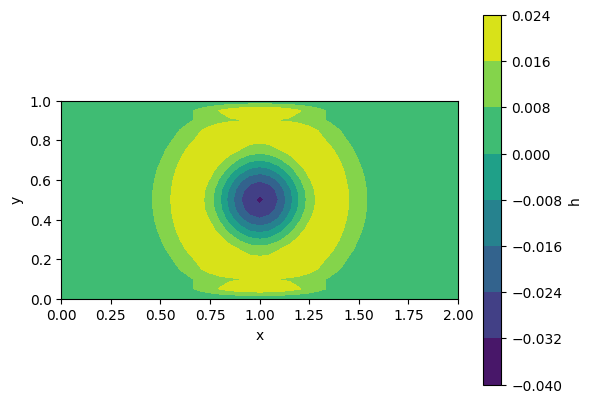

In [7]:
# visualization

h = state[nsteps%2, 2, :].reshape([M, N])

fig, ax = plt.subplots()
cs = ax.contourf(x, y, h)

ax.set_xlim(0, xmax)
ax.set_ylim(0, ymax)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_aspect('equal')

cbar = fig.colorbar(cs)
cbar.set_label('h')


plt.show()